In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import gillespie as gp

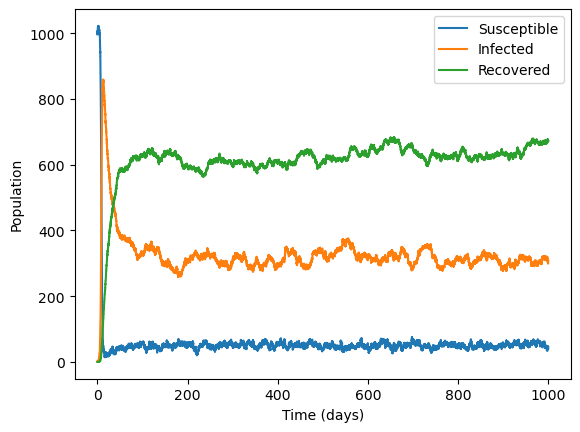

In [6]:
def gillespie_sir(X0, Y0, Z0, beta, gamma, mu, N, tend):
    # initialize arrays to store the variables
    X = [X0]
    Y = [Y0]
    Z = [Z0]
    t = [0]

    # Gillespie algorithm loop
    while t[-1] < tend:
        current_X = X[-1]
        current_Y = Y[-1]
        current_Z = Z[-1]
        
        # If no susceptible and infected, break out of the loop (epidemic is over)
        if current_Y == 0 and current_X == 0:
            break

        # Calculate rates for all events
        birth_rate = mu * N
        infection_rate = beta * current_X * current_Y / N
        recovery_rate = gamma * current_Y
        death_susc_rate = mu * current_X
        death_inf_rate = mu * current_Y
        death_recov_rate = mu * current_Z

        rates = [birth_rate, infection_rate, recovery_rate,
                 death_susc_rate, death_inf_rate, death_recov_rate]
        rate_sum = sum(rates)

        # if rate_sum is zero, no more events possible
        if rate_sum <= 0:
            break  # No more events can happen, end the simulation

        # Time until next event (exponentially distributed)
        tau = np.random.exponential(scale=1/rate_sum)
        t.append(t[-1] + tau)  # Append the new time

        rand = random.uniform(0, 1)*rate_sum

        # determine which event happens
        if rand < rates[0]: # birth event
            X.append(current_X+1)
            Y.append(current_Y)
            Z.append(current_Z)
        
        elif rand < rates[0] + rates[1]: # infection event
            if current_X > 0:
                X.append(current_X - 1)
                Y.append(current_Y + 1)
                Z.append(current_Z)
            else:
                X.append(current_X)
                Y.append(current_Y)
                Z.append(current_Z)
        
        elif rand < rates[0] + rates[1] + rates[2]: # recovery event
            if current_Y > 0:
                X.append(current_X)
                Y.append(current_Y - 1)
                Z.append(current_Z + 1)
            else:
                X.append(current_X)
                Y.append(current_Y)
                Z.append(current_Z)

        elif rand < rates[0] + rates[1] + rates[2] + rates[3]:  # death of susceptible
            if current_X > 0:
                X.append(current_X - 1)
                Y.append(current_Y)
                Z.append(current_Z)
            else:
                X.append(current_X)
                Y.append(current_Y)
                Z.append(current_Z)

        elif rand < rates[0] + rates[1] + rates[2] + rates[3] + rates[4]:  # death of infected
            if current_Y > 0:
                X.append(current_X)
                Y.append(current_Y - 1)
                Z.append(current_Z)
            else:
                X.append(current_X)
                Y.append(current_Y)
                Z.append(current_Z)

        else:  # death of recovered
            if current_Z > 0:
                X.append(current_X)
                Y.append(current_Y)
                Z.append(current_Z - 1)
            else:
                X.append(current_X)
                Y.append(current_Y)
                Z.append(current_Z)
    return X, Y, Z, t


N = 1000
tend = 1000 # simulation time (1000 days)
beta = 1
gamma = 1/30
mu = 1/60
X0 = 999
Y0 = 1
Z0 = 0

Xs, Ys, Zs, t = gillespie_sir(X0, Y0, Z0, beta, gamma, mu, N, tend)

# Plot the results
plt.plot(t, Xs, label="Susceptible")
plt.plot(t, Ys, label="Infected")
plt.plot(t, Zs, label="Recovered")

plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.legend()
plt.show()

#### This is the deterministic ODE

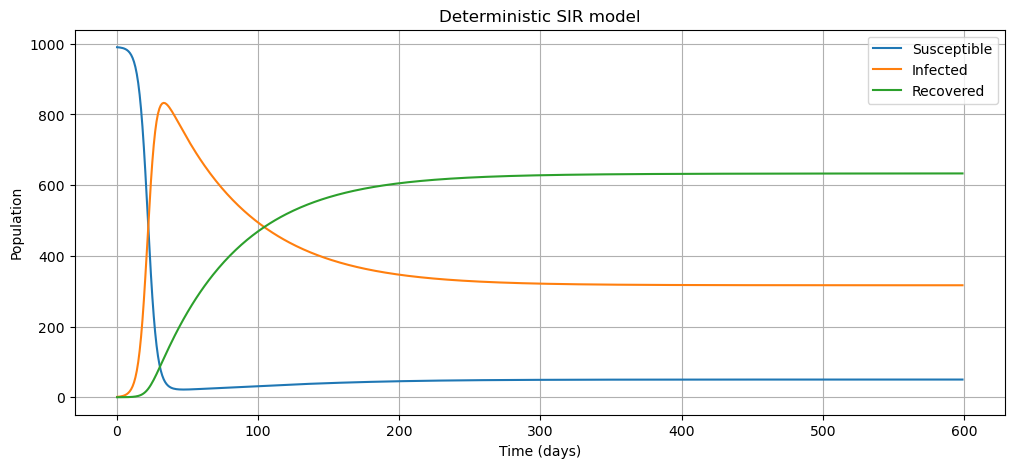

In [4]:
beta = 1
gamma = 1/30
mu = 1/60
N = 1000
X0 = 990
Y0 = 1
Z0 = 0
start_t = 0
end_t = 200
points_t = 600
init_val = [X0, Y0, Z0]

def SIR(X, t, beta, gamma, mu):
    """ 
    This function defines the ordinary differential equations for the compartments S, I and R. It then returns the differentials as an array.
    """
    X, Y, Z = X

    dXdt = mu * N - beta * X * Y / N - mu * X 
    dYdt = beta * X * Y / N - gamma * Y - mu * Y 
    dZdt = gamma * Y - mu * Z 
    
    return np.array([dXdt, dYdt, dZdt])


def deterSol(X0, Y0, Z0, N, beta, gamma, mu, start_t, end_t, points_t):

    time = np.linspace(start_t, end_t, points_t)
    solution = odeint(SIR, init_val, time, args=(beta, gamma, mu))
    Xd, Yd, Zd = solution.T

    return Xd, Yd, Zd, time


Xd, Yd, Zd, time = deterSol(X0, Y0, Z0, N, beta, gamma, mu, start_t, end_t, points_t)

plt.figure(figsize=(12,5))
plt.plot(Xd, label="Susceptible")
plt.plot(Yd, label="Infected")
plt.plot(Zd, label = "Recovered")
plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.title("Deterministic SIR model")
plt.legend()
plt.grid()

# plt.savefig('FittingSIR.png', dpi=300)
plt.show()


#### This is the Stochastic thing

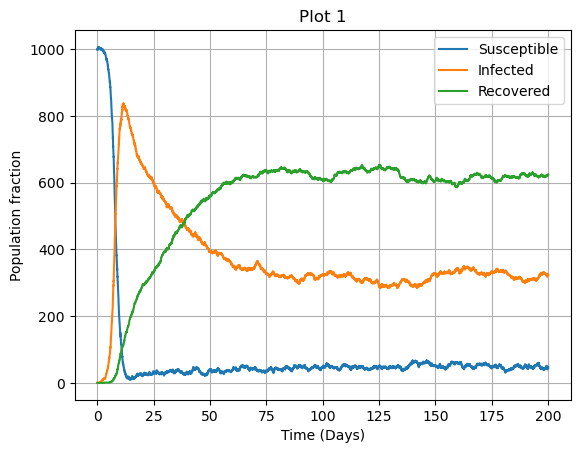

In [46]:
beta = 1
gamma = 1/30
mu = 1/60
N = 1000
X0 = 999
Y0 = 1
Z0 = 0
init_val = [X0, Y0, Z0]

def gillespie_SIR(X, Y, Z, N, beta, gamma, mu):
    propensities = [lambda X, Y, Z: mu * N,
                lambda X, Y, Z: beta * X * Y / N,
                lambda X, Y, Z: gamma * Y,
                lambda X, Y, Z: mu * X,
                lambda X, Y, Z: mu * Y,
                lambda X, Y, Z: mu * Z]

    stoichiometry = [[1, 0, 0],
                 [-1, 1, 0],
                 [0, -1, 1],
                 [-1, 0, 0],
                 [0, -1, 0],
                 [0, 0, -1]]

    times, XYZ = gp.simulate(init_val, propensities, stoichiometry, duration = 200) 

    Xs, Ys, Zs = zip(*XYZ)

    return Xs, Ys, Zs, times

Xs, Ys, Zs, times = gillespie_SIR(X0, Y0, Z0, N, beta, gamma, mu)


plt.plot(times, Xs, label = "Susceptible")
plt.plot(times, Ys, label = "Infected")
plt.plot(times, Zs, label = "Recovered")

plt.title("Plot 1")
plt.xlabel("Time (Days)")
plt.ylabel("Population fraction")
plt.legend()
plt.grid()

plt.show()

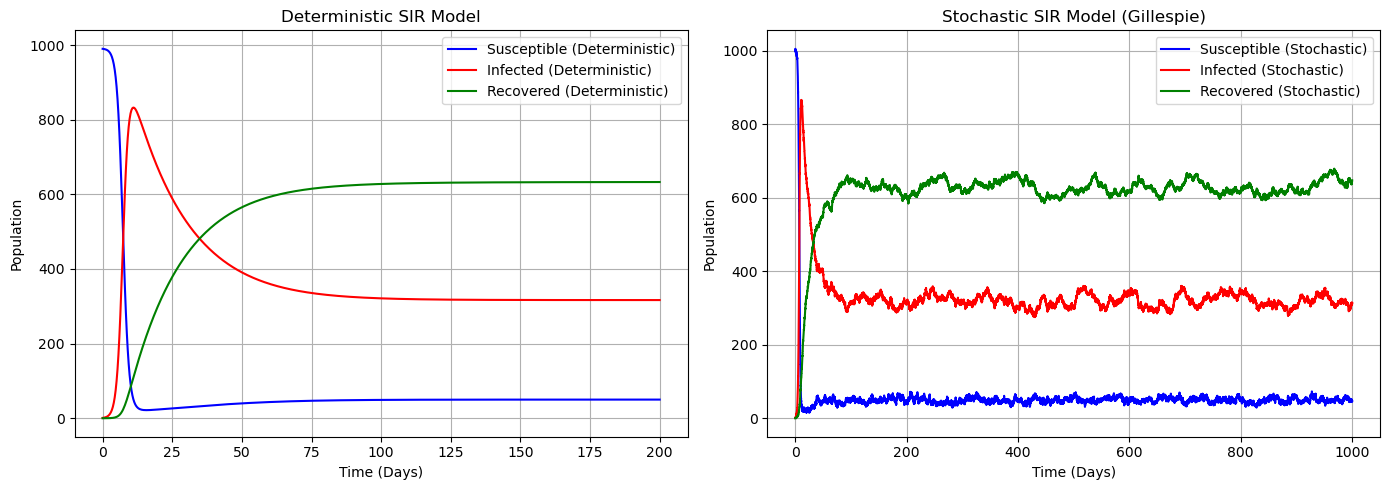

In [16]:
# Plot both the deterministic and stochastic models on the same figure

# First, solve the deterministic model
Xd, Yd, Zd, time = deterSol(X0, Y0, Z0, N, beta, gamma, mu, start_t, end_t, points_t)

# Now, solve the stochastic model using the Gillespie algorithm
# Xs, Ys, Zs, times = gillespie_sir(X0, Y0, Z0, N, beta, gamma, mu)
Xs, Ys, Zs, t = gillespie_sir(X0, Y0, Z0, beta, gamma, mu, N, tend)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot the deterministic model on the first subplot (ax1)
ax1.plot(time, Xd, label="Susceptible (Deterministic)", color='blue')
ax1.plot(time, Yd, label="Infected (Deterministic)", color='red')
ax1.plot(time, Zd, label="Recovered (Deterministic)", color='green')
ax1.set_title("Deterministic SIR Model")
ax1.set_xlabel("Time (Days)")
ax1.set_ylabel("Population")
ax1.legend(loc="best")
ax1.grid(True)

# Plot the stochastic model on the second subplot (ax2)
ax2.plot(t, Xs, label="Susceptible (Stochastic)", color='blue')
ax2.plot(t, Ys, label="Infected (Stochastic)", color='red')
ax2.plot(t, Zs, label="Recovered (Stochastic)", color='green')
ax2.set_title("Stochastic SIR Model (Gillespie)")
ax2.set_xlabel("Time (Days)")
ax2.set_ylabel("Population")
ax2.legend(loc="best")
ax2.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [57]:
import numpy as np
import statistics as st

sims = 50

# Assuming gillespie_sir is defined elsewhere
def run_stoch_sim(sims, X0, Y0, Z0, beta, gamma, mu, N, tend):
    mean_Xs_list = []
    mean_Ys_list = []
    var_Xs_list = []
    var_Ys_list = []

    all_Xs = []  # This will accumulate Xs from all simulations
    all_Ys = []  # This will accumulate Ys from all simulations

    for i in range(sims):
        # Run the Gillespie simulation for the current iteration
        Xs, Ys, Zs, t = gillespie_sir(X0, Y0, Z0, beta, gamma, mu, N, tend)

        # Compute and store the mean of Xs and Ys for this simulation
        mean_Xs = st.mean(Xs)
        mean_Ys = st.mean(Ys)

        mean_Xs_list.append(mean_Xs)
        mean_Ys_list.append(mean_Ys)

        # Append current Xs and Ys to accumulate over all simulations
        all_Xs.append(Xs)
        all_Ys.append(Ys)

        # Convert lists to numpy arrays for variance calculation
        all_Xs_np = np.array(all_Xs)
        all_Ys_np = np.array(all_Ys)

        # Compute variance across the simulations at every iteration (axis=0 to get variance at each time step)
        if len(all_Xs) > 1:  # To compute variance, we need at least two simulations
            var_Xs = np.var(all_Xs_np, axis=0)
            var_Ys = np.var(all_Ys_np, axis=0)

            # Store variance after each iteration
            var_Xs_list.append(var_Xs)
            var_Ys_list.append(var_Ys)

    return mean_Xs_list, mean_Ys_list, var_Xs_list, var_Ys_list

# Parameters (Assuming they are defined elsewhere)
X0 = 999
Y0 = 1
Z0 = 0
beta = 0.9
gamma = 0.3
mu = 0.0001
N = X0 + Y0 + Z0
tend = 1000

# Run the stochastic simulations
mean_Xs_list, mean_Ys_list, var_Xs_list, var_Ys_list = run_stoch_sim(sims, X0, Y0, Z0, beta, gamma, mu, N, tend)

# Print the results
print(f"Number of simulations: {len(mean_Xs_list)}")
print(f"Final mean of Susceptibles: {mean_Xs_list[-1]}")
print(f"Final variance of Susceptibles: {var_Xs_list[-1]}")
print(f"Final mean of Infected: {mean_Ys_list[-1]}")
print(f"Final variance of Infected: {var_Ys_list[-1]}")

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.